# Overview

- Kiểm tra dữ liệu bị trùng lặp

- Kiểm tra xữ liệu bị missing trừ cột attribute_time

Notebook này có 2 phần chính:

**Phân tích tập mẫu 10 triệu rows đầu tiên**

    - Số lượng các giá trị unique của mỗi feature
    
    - Tỉ lệ số lần app được download
    
    - Conversion tỉ lệ download trên tổng số lần click của mỗi feature
    
    - Phân tích dữ liệu về ip
    
**Phân tích dữ liệu thời gian**

    - Thời gian thu thập dữ liệu
    
    - Tỉ lệ app được download theo giờ
    
    - Thời gian app được download sau khi được click ad

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});
plt.figure(figsize=(12,5));

**Lấy 10 triệu rows đầu**

In [3]:
#import first 10,000,000 rows of train and all test data
train = pd.read_csv('../input/train.csv', nrows=10000000)
test = pd.read_csv('../input/test.csv')

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


Mỗi hàng dữ liệu huấn luyện chứa một bản ghi về việc nhấp chuột, với các đặc trưng sau đây:

- ip: địa chỉ IP của sự nhấp chuột
- app: ID ứng dụng để tiếp thị
- device: ID loại thiết bị của điện thoại di động người dùng
- os: ID phiên bản hệ điều hành của điện thoại di động người dùng
- channel: ID của nhà xuất bản quảng cáo di động (đó là ID của trang web trên đó quảng cáo được xuất bản)
- click_time: dấu thời gian của sự nhấp chuột (UTC)
- is_attributed: mục tiêu cần được dự đoán, chỉ định rằng ứng dụng đã được tải xuống

Chúng ta có thể quan sát rằng giá trị của attributed_time là NaN. Đặc điểm attributed_time sẽ có giá trị NaN đối với người dùng chưa tải ứng dụng sau khi nhấp vào quảng cáo ứng dụng (is_attributed = 0), và attributed_time sẽ có giá trị thời gian tương tự như click_time đối với người dùng đã tải ứng dụng sau khi nhấp vào quảng cáo ứng dụng (is_attribute = 1).

In [5]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [6]:
# checking for the duplicated rows
sum(train.duplicated(subset = list(train.columns)))

221295

In [7]:
# deleting the duplicate rows
train.drop_duplicates(subset = list(train.columns), keep = 'first', inplace = True)

In [8]:
# getting the number of datapoints and features in the dataset

data_points, features = train.shape

print("*"*50)
print("The number of data points present are :", data_points)
print("The number of features are :", features)

**************************************************
The number of data points present are : 9778705
The number of features are : 8


In [9]:
# Check for null values in all columns except 'attributed_time'
columns_to_check = train.columns.difference(["attributed_time"])
null_counts = train[columns_to_check].isnull().sum()

print(null_counts)

app              0
channel          0
click_time       0
device           0
ip               0
is_attributed    0
os               0
dtype: int64


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9778705 entries, 0 to 9999999
Data columns (total 8 columns):
ip                 int64
app                int64
device             int64
os                 int64
channel            int64
click_time         object
attributed_time    object
is_attributed      int64
dtypes: int64(6), object(2)
memory usage: 671.5+ MB


ip, app, device, os and channel are actually categorical variables encoded as integers.   Set them as categories for analysis.

In [11]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train[v] = train[v].astype('category')
    test[v]=test[v].astype('category')

Convert date stamps to date/time type.

In [12]:
#set click_time and attributed_time as timeseries
train['click_time'] = pd.to_datetime(train['click_time'])
train['attributed_time'] = pd.to_datetime(train['attributed_time'])
test['click_time'] = pd.to_datetime(test['click_time'])

#set as_attributed in train as a categorical
train['is_attributed']=train['is_attributed'].astype('category')

Now lets do a quick inspection of train and test data main statistics

*this graph is adapted from https://www.kaggle.com/anokas/talkingdata-adtracking-eda*:

### Table 1: Số lượng giá trị unique của mỗi feature

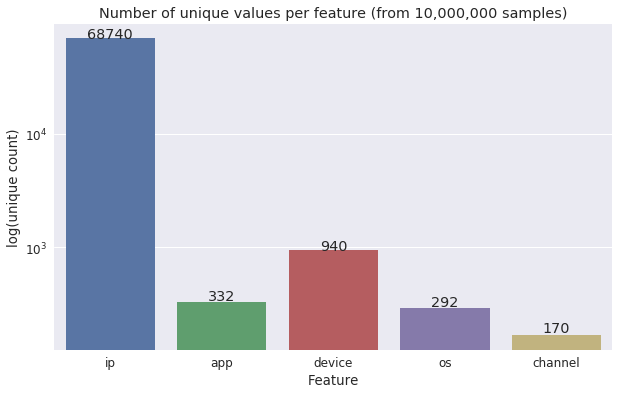

In [13]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature (from 10,000,000 samples)')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

In [14]:
#double check that 'attributed_time' is not Null for all values that resulted in download (i.e. is_attributed == 1)
train[['attributed_time', 'is_attributed']][train['is_attributed']==1].describe()

,attributed_time,is_attributed
count,18717,18717.0
unique,15698,1.0
top,2017-11-06 23:36:23,1.0
freq,6,18717.0
first,2017-11-06 16:00:47,NaN
last,2017-11-07 15:59:53,NaN


In [15]:
#set click_id to categorical, for cleaner statistics view
test['click_id']=test['click_id'].astype('category')
test.describe()

,click_id,ip,app,device,os,channel,click_time
count,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469.0,18790469
unique,18790469.0,93936.0,417.0,1985.0,395.0,178.0,21603
top,18790468.0,5348.0,9.0,1.0,19.0,107.0,2017-11-10 09:00:10
freq,1.0,182522.0,2872176.0,17360269.0,4334532.0,1214650.0,1466
first,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 04:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-10 15:00:00


Only a small proportion of clicks were followed by a download.We can see that the dataset is highly imbalance.:

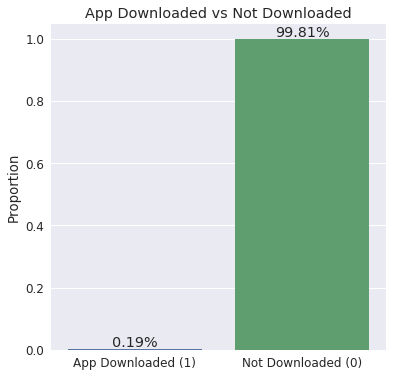

In [16]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Proportion', title='App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

### Explore ip counts.  Check if multiple ips have any downloads.

At this point I was trying to figure out what 'ip' were actually encoding.  My original understanding that ips were user specific did not hold up to scrutiny.
If ip repeated too many times, was it a bot?  This does not appear to be true, as repeated ips do convert.  See below:

In [17]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73516,50896
1,73487,50347
2,5314,34273
3,5348,34264
4,53454,24930
5,105560,22636
6,100275,22437
7,114276,22373
8,201182,22170
9,105475,21470


In [18]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have conversions
train= train.merge(temp, on='ip', how='left')

In [19]:
#check top 10 values
train[train['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
6196351,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,50896
1840305,73516,10,1,6,113,2017-11-06 16:46:37,2017-11-06 18:15:53,1,50896
5925103,73516,29,1,19,343,2017-11-06 22:21:59,2017-11-06 22:27:52,1,50896
7316556,73516,150,1,22,110,2017-11-06 23:16:16,2017-11-07 03:50:25,1,50896
6824760,73516,19,154,24,213,2017-11-06 23:00:47,2017-11-06 23:05:56,1,50896
2510064,73516,29,1,22,213,2017-11-06 17:09:58,2017-11-06 18:09:28,1,50896
7743158,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,50896
6880910,73516,20,1,13,259,2017-11-06 23:02:41,2017-11-06 23:09:53,1,50896
8296285,73516,72,1,36,101,2017-11-06 23:41:59,2017-11-07 00:08:18,1,50896
2203103,73516,10,1,22,317,2017-11-06 16:58:31,2017-11-06 22:51:34,1,50896


In [20]:
train[train['is_attributed']==1].ip.describe()

count     18717
unique    16112
top       73487
freq         56
Name: ip, dtype: int64

#### Comaprision between top 5 ips most fraudlent and download clicks

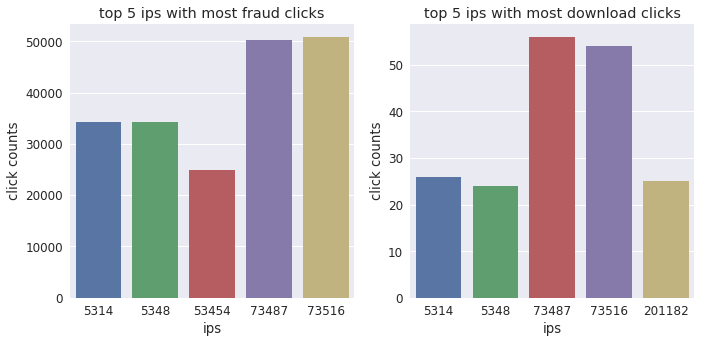

In [21]:
# top 5 ips with most fraudlent and download clicks
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
fraud_ips = sorted(dict(train[train['is_attributed'] == 0]['ip'].value_counts()).items(),key = lambda x : x[1],reverse=True)[0:5]
ips = []
count = []
for pair in fraud_ips:
    ips.append(pair[0])
    count.append(pair[1])
sns.barplot(ips,count)
plt.title('top 5 ips with most fraud clicks')
plt.xlabel('ips')
plt.ylabel('click counts')

# top 5 ips with most download clicks
plt.subplot(1,2,2)
download_ips = sorted(dict(train[train['is_attributed'] == 1]['ip'].value_counts()).items(),key = lambda x:x[1],reverse=True)[0:5]
ips = []
count = []
for pair in download_ips:
    ips.append(pair[0])
    count.append(pair[1])

sns.barplot(ips,count)
plt.title('top 5 ips with most download clicks')  
plt.xlabel('ips')
plt.ylabel('click counts')

plt.tight_layout()

So high frequency ip counts do get conversions.   Up to 56 downloads for one ip (ip 73487).  We can also see that ips with most clicks in the cases are almost same.  Each IP must be for some network with many devices.

#### Comaprision between top 5 os most fraudlent and download clicks

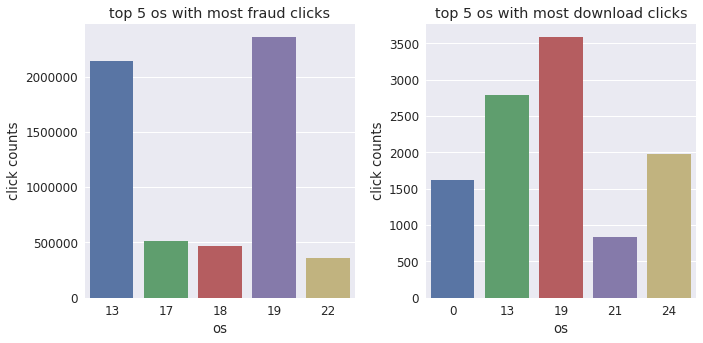

In [22]:
# top 5 os with most fraudlent and download clicks
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
fraud_ips = sorted(dict(train[train['is_attributed'] == 0]['os'].value_counts()).items(),key = lambda x : x[1],reverse=True)[0:5]
ips = []
count = []
for pair in fraud_ips:
    ips.append(pair[0])
    count.append(pair[1])
sns.barplot(ips,count)
plt.title('top 5 os with most fraud clicks')
plt.xlabel('os')
plt.ylabel('click counts')

# top 5 os with most download clicks
plt.subplot(1,2,2)
download_ips = sorted(dict(train[train['is_attributed'] == 1]['os'].value_counts()).items(),key = lambda x:x[1],reverse=True)[0:5]
ips = []
count = []
for pair in download_ips:
    ips.append(pair[0])
    count.append(pair[1])

sns.barplot(ips,count)
plt.title('top 5 os with most download clicks')  
plt.xlabel('os')
plt.ylabel('click counts')

plt.tight_layout()

OS 13 and 19 are the most used with most clicks not leading to download as well as download.

#### Comaprision between top 5 channels most fraudlent and download clicks

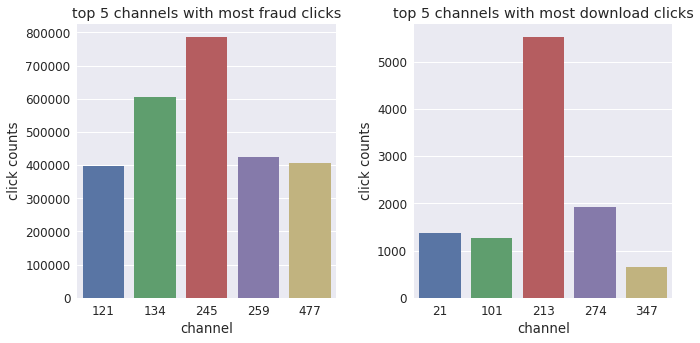

In [23]:
# top 5 channels with most fraudlent and download clicks
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
fraud_ips = sorted(dict(train[train['is_attributed'] == 0]['channel'].value_counts()).items(),key = lambda x : x[1],reverse=True)[0:5]
ips = []
count = []
for pair in fraud_ips:
    ips.append(pair[0])
    count.append(pair[1])
sns.barplot(ips,count)
plt.title('top 5 channels with most fraud clicks')
plt.xlabel('channel')
plt.ylabel('click counts')

# top 5 apps with most download clicks
plt.subplot(1,2,2)
download_ips = sorted(dict(train[train['is_attributed'] == 1]['channel'].value_counts()).items(),key = lambda x:x[1],reverse=True)[0:5]
ips = []
count = []
for pair in download_ips:
    ips.append(pair[0])
    count.append(pair[1])

sns.barplot(ips,count)
plt.title('top 5 channels with most download clicks')  
plt.xlabel('channel')
plt.ylabel('click counts')

plt.tight_layout()

All the other channels are completely different in both the cases.

#### Comaprision between top 5 apps most fraudlent and download clicks

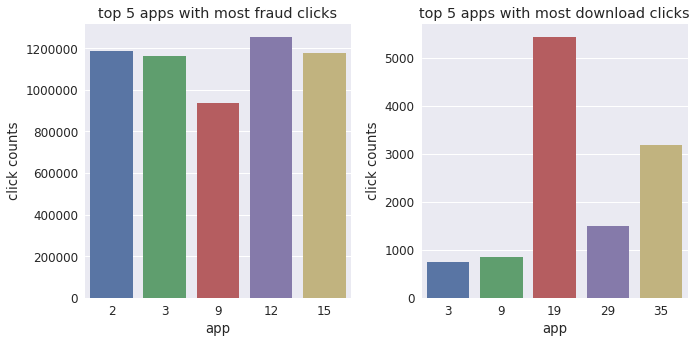

In [24]:
# top 5 apps with most fraudlent and download clicks
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
fraud_ips = sorted(dict(train[train['is_attributed'] == 0]['app'].value_counts()).items(),key = lambda x : x[1],reverse=True)[0:5]
ips = []
count = []
for pair in fraud_ips:
    ips.append(pair[0])
    count.append(pair[1])
sns.barplot(ips,count)
plt.title('top 5 apps with most fraud clicks')
plt.xlabel('app')
plt.ylabel('click counts')

# top 5 apps with most download clicks
plt.subplot(1,2,2)
download_ips = sorted(dict(train[train['is_attributed'] == 1]['app'].value_counts()).items(),key = lambda x:x[1],reverse=True)[0:5]
ips = []
count = []
for pair in download_ips:
    ips.append(pair[0])
    count.append(pair[1])

sns.barplot(ips,count)
plt.title('top 5 apps with most download clicks')  
plt.xlabel('app')
plt.ylabel('click counts')

plt.tight_layout()

We can see that the apps in both the case are completely different. There are certain set of happens on which there are most fraud clicks.

In [25]:
#convert 'is_attributed' back to numeric for proportion calculations
train['is_attributed']=train['is_attributed'].astype(int)

**Nhận xét** :
- Có 18717 attributed_time values.  Chiếm tỉ lệ thấp hơn 0.2% !. Từ đó kết luận dataset này highly imbalance. 
- Có những ip được click hơn 50 nghìn lần chỉ trong vòng vài ngày. 
- Train và Test không bị overlap bởi vì data được lấy tổng trong 5 ngày, trong đó 4 ngày đầu thuộc data train (Từ thứ 2 - thứ 5) và ngày cuối (thứ 6) thuộc data test. 
- Không có mising data trừ col attributed_time
- Có sự khác biệt giữa những app và channel có tỉ lệ download nhiều nhất và ngược lại.
- OS 13 và 19 được dùng nhiều nhất trong cả 2 trường hợp 

## Conversion feature

**Nhận xét chung: 
Nhìn chung mỗi feature đều có sự chênh lệch lớn về số lần click ad giữa các giá trị. Với các giá trị có số lần click cao, tỉ lệ app được tải giao động ở khoảng 0.0001-0.00015**

### Conversion rates over Counts of 300 most popular IPs

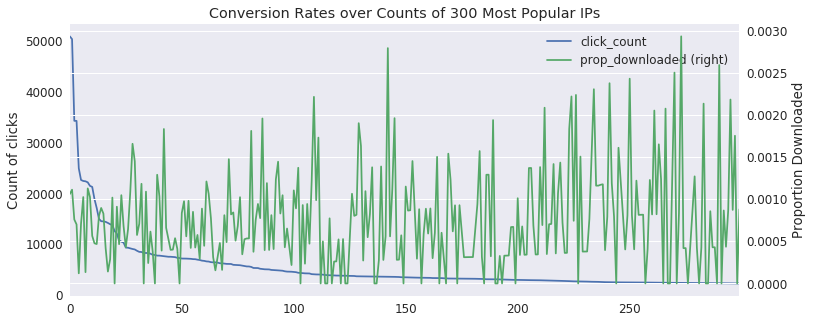



**************************************************
Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0    73516        50896         0.001061
1    73487        50347         0.001112
2     5314        34273         0.000759
3     5348        34264         0.000700
4    53454        24930         0.000120
5   105560        22636         0.000707
6   100275        22437         0.001025
7   114276        22373         0.000134
8   201182        22170         0.001128
9   105475        21470         0.001025
10   95766        21274         0.000564
11   26995        18888         0.000476
12  209663        17123         0.000467
13   43793        15004         0.000800
14   17149        14517         0.000896
15  137052        14488         0.000828
16   86767        14390         0.000417
17  111025        14179         0.000141
18  138561        13931         0.000287
19  147957        13747         0.001018


In [26]:
proportion = train[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print("\n")
print("*"*50)
print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])


Conversions are noisy and do not appear to correlate with how popular an IP is.

### Conversions by App

Check 100 most popular apps by click count:

     app  is_attributed
293  443       1.000000
284  395       1.000000
171  196       1.000000
207  246       1.000000
109  116       0.882353
   app  is_attributed
12  12        1254610
2    2        1188610
15  15        1175462
3    3        1163732
9    9         938682


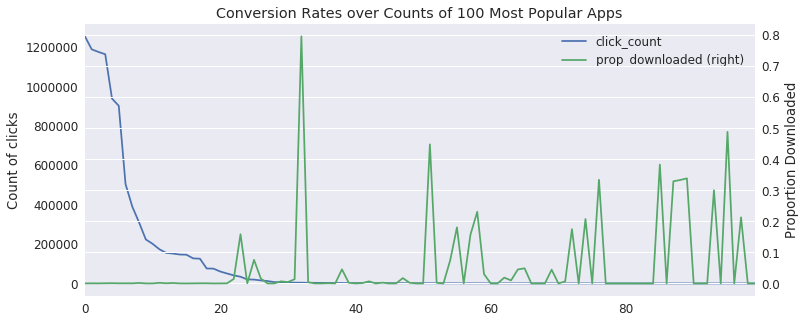



**************************************************
Counversion Rates over Counts of Most Popular Apps
   app  click_count  prop_downloaded
0   12      1254610         0.000144
1    2      1188610         0.000393
2   15      1175462         0.000278
3    3      1163732         0.000633
4    9       938682         0.000895
5   18       901980         0.000404
6   14       504710         0.000485
7    1       390110         0.000351
8    8       310010         0.001693
9   21       223540         0.000089
10  13       201379         0.000104
11  20       173917         0.001972
12  24       155445         0.000553
13  11       151912         0.001507
14   6       147002         0.000177
15  23       146148         0.000027
16  64       127439         0.000259
17  26       125853         0.000540
18  27        76095         0.000526
19  28        75449         0.000066


In [27]:
proportion = train[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
print(proportion.head())
counts = train[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
print(counts.head())
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print("\n")
print("*"*50)
print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

There is a again a huge difference in clicks per app. Clicks per app vary widely, ranging from one to nearly 13 million. Proportions of clicks to counts are more sensitive to changes when counts are low. Apps with counts in the thousands generally maintain a stable ratio, staying within the 0.0001 to 0.0015 range. Less popular apps, with lower counts, exhibit greater fluctuation in the click-to-count ratio.

### Conversions by OS
Look at top 100 operating systems by click count

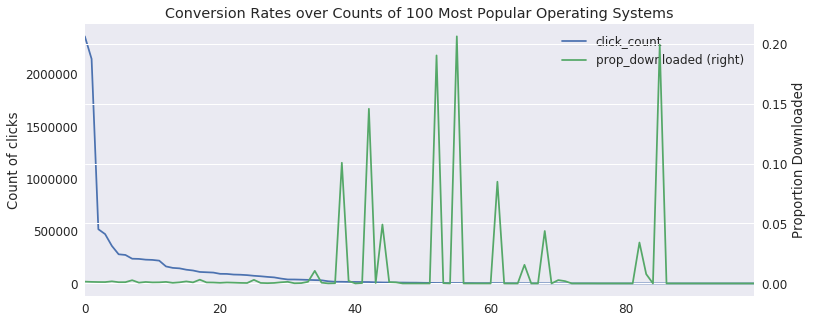



**************************************************
Counversion Rates over Counts of Most Popular Operating Systems
     os  click_count  prop_downloaded
0    19      2361262         0.001520
1    13      2145718         0.001303
2    17       518218         0.001185
3    18       471575         0.001143
4    22       358721         0.001762
5    10       278801         0.001037
6     8       272372         0.001065
7     6       236423         0.002690
8     9       234646         0.000669
9    25       227451         0.001231
10   15       225000         0.000876
11   20       217935         0.000945
12   16       162746         0.001284
13   37       148842         0.000517
14    3       144340         0.000942
15   14       131507         0.001696
16   41       123887         0.000896
17    1       109972         0.003137
18  607       107087         0.000859
19   12       104077         0.000778


In [28]:
proportion = train[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print("\n")
print("*"*50)
print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

Same story. For values in the thousands the boundary on the ratio is very low, roughly between 0.0006 and 0.003, but as counts on OS become lower, the ratio starts fluxuating more wildely.

### Conversions by Device

Devices are extremely disproportionately distributed, with number one device used almost 94% of time.  For that device proportion download was 0.001356. (0.13%)

In [29]:
proportion = train[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']
merge = merge.sort_values(by='click_count', ascending=False)

print('Count of clicks and proportion of downloads by device:')
print(merge[:20])

Count of clicks and proportion of downloads by device:
   device  click_count  prop_downloaded
0       1      9169214         0.001356
1       2       449198         0.000211
2    3032       104126         0.000000
3       0        45052         0.094868
4      59         1594         0.001255
5      40          454         0.251101
6       6          452         0.225664
7      16          331         0.244713
8      18          243         0.230453
9      33          204         0.196078
10     21          186         0.247312
11    154          150         0.180000
12   3033          143         0.188811
13     37          142         0.197183
14     30          125         0.304000
15     46          122         0.213115
17      7          119         0.235294
16    114          119         0.176471
18     88          115         0.330435
19    109          113         0.300885


### Conversions by Channel


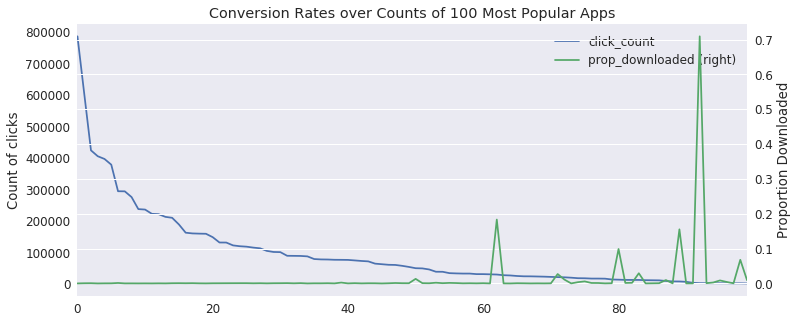

Counversion Rates over Counts of Most Popular Channels
   channel  click_count  prop_downloaded
0      245       786360         0.000106
1      134       604925         0.000582
2      259       424403         0.000723
3      477       405775         0.000074
4      121       397061         0.000327
5      107       378948         0.000388
6      145       294591         0.001368
7      153       294262         0.000184
8      205       276063         0.000235
9      178       237870         0.000135
10     265       236399         0.000237
11     128       222922         0.000130
12     140       221750         0.000347
13     459       213238         0.000188
14     442       210240         0.000647
15     215       189144         0.000788
16     122       162964         0.000583
17     379       160663         0.000815
18     280       159980         0.000350
19     135       159538         0.000201


In [30]:
proportion = train[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

There appear to be a few peaks for channels at reasonable click quantity, but overall the pattern holds same as for categories above.  

## BE CAREFUL about IPs as a signal

Vấn đề này được rất nhiều người bàn luận https://www.kaggle.com/yuliagm/be-careful-about-ips-as-a-signal

**Overall the number of IPs (test OR train): 333168**

**Number of IPs that are in both (test AND train): 38164**

**Number of IPs that are in Train and NOT in Test: 239232**

**Number of IPs that are in Test and NOT in Train: 55772**

In [31]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

train = pd.read_csv('../input/train.csv', dtype=dtypes, usecols=['ip', 'is_attributed'])
test = pd.read_csv('../input/test.csv', dtype=dtypes, usecols=['ip'])

In [32]:
test.describe()

,ip
count,1.879047e+07
mean,6.306921e+04
std,3.688597e+04
min,0.000000e+00
25%,3.155800e+04
50%,6.393600e+04
75%,9.531600e+04
max,1.264130e+05


In [33]:
df = train.groupby('ip').is_attributed.mean().to_frame().reset_index()

Text(0,0.5,'Proportion Downloaded')

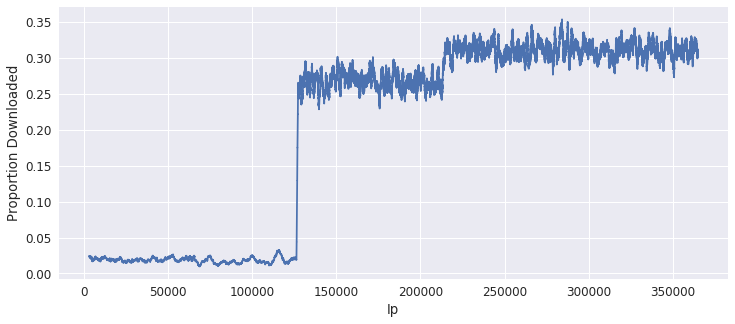

In [34]:
df['roll'] = df.is_attributed.rolling(window=1000).mean()
plt.plot(df.ip, df.roll)
plt.xlabel("Ip")
plt.ylabel("Proportion Downloaded")

**Có thể thấy có 2 khoảng cắt rất rõ ràng đó là ở ip từ 120000 (tỉ lệ download tăng từ 0.02 lên hơn 0.25) và 210000 (tăng từ 0.25 lên hơn 0.3)**

Có thể lý giải bằng giả thuyết như sau: Trong tập train, các ip được sort theo số lượng click từ lớn đến bé, khoảng 120000 ip đầu tiên là những ip có lượt click cao nhất chính vì vậy mà tỉ lệ download cũng là thấp nhất (khoảng 0.02%), và các ip lớn hơn từ 120000 có lượt click ad thấp chính vì thế tỉ lệ download cũng cao hơn.

+ Có khi nào ip ở tập train và test được mã hóa độc lập? (Bởi vì dải ip của test chỉ đến 180000) Nếu đúng như vậy thì feature này liệu có tốt?

# Checking for time patterns

Kì lạ là thời gian click ad kéo dài từ 0h đêm đến 3h chiều ngày hôm sau => Ngày ngủ đêm bay? Hoặc có thể múi giờ bị sử dụng lệch chăng?

In [35]:
train_smp = pd.read_csv('../input/train_sample.csv')

In [36]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

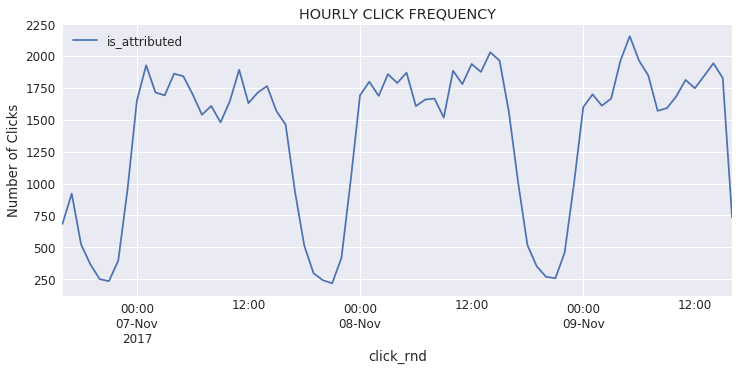

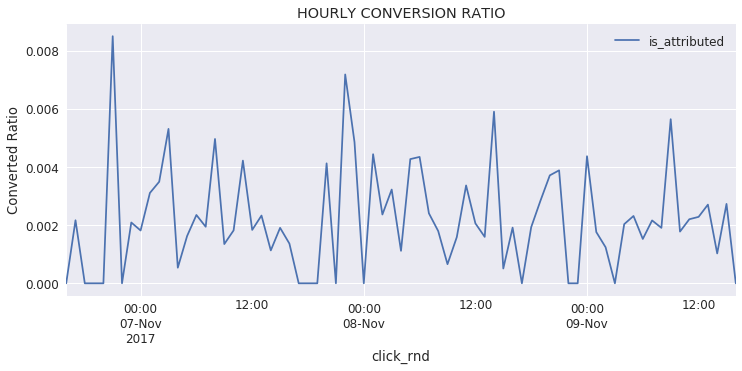

In [37]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

There is no clear hourly time pattern in ratios, however there is a definete pattern in frequency of clicks based on time of day.

Lets extract the hour of day from each day as a separate feature, and see combined trend (merge the 4 days together by hour).

In [38]:
#extract hour as a feature
train_smp['click_hour']=train_smp['click_time'].dt.hour

In [39]:
train_smp.head(7)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9
5,93663,3,1,17,115,2017-11-09 01:22:13,NaT,0,2017-11-09 01:00:00,1
6,17059,1,1,17,135,2017-11-09 01:17:58,NaT,0,2017-11-09 01:00:00,1


Let's check number of clicks by hour:

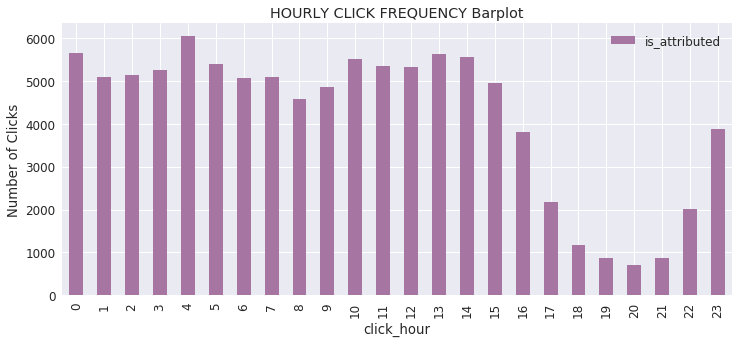

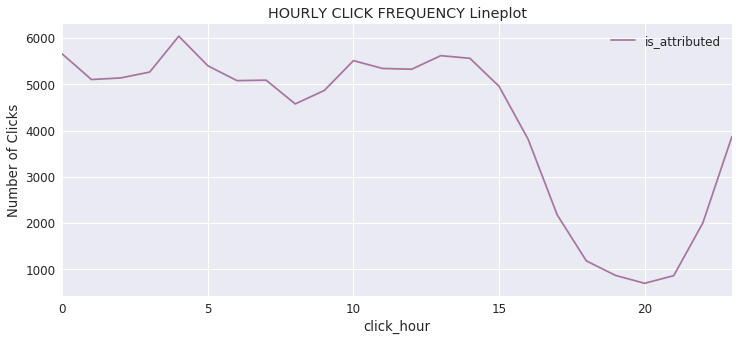

In [40]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

Chúng ta có thể thấy rằng số lượt nhấp chuột cao từ 0 giờ sáng đến 3 giờ chiều và sau 8 giờ chiều.

And number of conversions by hours:

let's overlay the two graphs to see if patterns correlate in any way

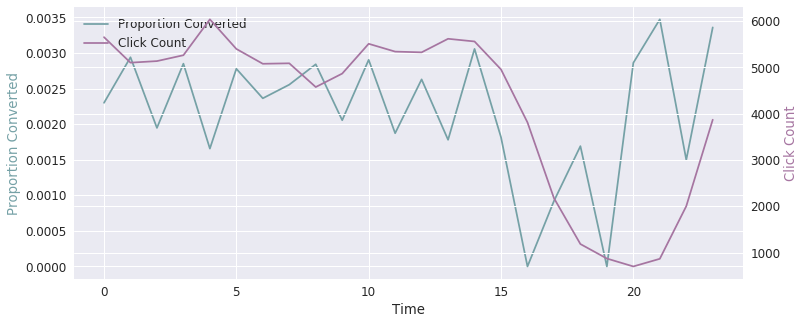

In [41]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

The proportions may be more reliable if estimated on full data.  With the random sample it's  hard too tell because the variability is too high, especially for the hours with low click counts.   i.e. the fewer clicks/conversions, the wider margin of the estimated conversion ratio.  (see below)

We will see number of fraud clicks every hour in a day

In [42]:
train_smp.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9


### Look into attributed_time
Sau cú click ad bao lâu thì app được download?

In [43]:
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']
#check:
train_smp[train_smp['is_attributed']==1][:15]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,timePass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,01:39:29


In [44]:
train_smp['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

**Trong tập dữ liệu sample này có thể thấy khoảng thời gian chênh lệch lâu nhất giữa click và download là gần 13h, thấp nhất là khoảng 2s**

Câu hỏi đặt ra là, liệu có ai có thể vừa xem ad được 2s thì đã download k? Có thể họ biết từ trước (thông qua việc xem cái ad này nhiều lần hoặc nghe ngóng từ nguồn nào đó) hoặc có thể đó là 1 con bot?

### Check actual train data (the first 10,000,000)
double check the same feature on the first 10 million rows of train data:

In [52]:
#check first 10,000,000 of actual train data
train['timePass']= train_smp['attributed_time']-train_smp['click_time']
train['timePass'].describe()

count                     18717
mean     0 days 03:48:02.893732
std      0 days 05:29:41.396810
min             0 days 00:00:00
25%             0 days 00:01:26
50%             0 days 00:25:03
75%             0 days 06:34:14
max             0 days 23:52:38
Name: timePass, dtype: object

**Trong tập 10 triêu dòng đầu của dữ liệu train, thời gian nhỏ nhất giữa việc click và down giảm xuống 0 và dài nhất thì tăng lên gần 24h**